Load data!
1. geneData: gene expression data
2. phenotypes: other data about the samples
3. survivalData: rates, times, etc. related to survival

In [14]:
# phenotype data to get sample_type
import pandas as pd

geneData = pd.read_csv("TCGA.STAD.sampleMap_HiSeqV2_PANCAN.tsv", sep='\t', low_memory=False, index_col=0, header=None)
geneData = geneData.transpose() # list samples horizontally

phenotypes = pd.read_csv("TCGA.STAD.sampleMap_STAD_clinicalMatrix.tsv", sep='\t')
phenotypes.rename(columns={"sampleID": "sample"}, inplace=True) # match sample labels' column name

survivalData = pd.read_csv("Survival Data - Stomach Cancer.csv", low_memory=False, index_col=0)

# COMBINED DATA
df = pd.merge(geneData, phenotypes, on='sample', how='inner')
df = pd.merge(df, survivalData, on='sample', how='inner')

df.drop_duplicates(subset='_PATIENT_y', keep='first', inplace=True)
    # removing duplicate patients because we will be doing analysis on how gender, age, etc. will affect survival too
df.head(10)

,sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,_PATIENT_y,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-FP-A4BE-01,1.22480753024,-1.74772633632,-0.531035005853,-0.257771985954,0.019121865002,-0.376309910261,-0.627894490831,0.0507543425673,-0.423399406945,...,TCGA-FP-A4BE,0,337.0,0.0,337.0,0.0,337.0,0,337.0,NaN
1,TCGA-BR-8081-01,0.614507530238,-0.110026336325,-0.531035005853,0.026728014046,-0.550378134998,-0.398609910261,-0.846094490831,1.18205434257,0.615700593055,...,TCGA-BR-8081,0,981.0,0.0,981.0,0.0,981.0,0,981.0,NaN
2,TCGA-HU-A4GP-11,-0.051192469762,6.49987366368,0.273964994147,0.397228014046,1.116121865,0.0959900897386,0.592805509169,2.94125434257,0.034600593055,...,TCGA-HU-A4GP,0,273.0,0.0,273.0,0.0,273.0,0,273.0,NaN
3,TCGA-IN-7806-01,2.24880753024,4.36007366368,-0.531035005853,0.252328014046,-0.463778134998,-0.768109910261,-0.311694490831,0.710954342567,-0.423399406945,...,TCGA-IN-7806,0,1106.0,0.0,1106.0,0.0,1106.0,0,1106.0,NaN
4,TCGA-BR-4257-01,-0.589492469762,-3.20082633632,-0.531035005853,-0.484871985954,-0.431178134998,0.425990089739,-0.364494490831,-0.891645657433,1.09720059306,...,TCGA-BR-4257,1,294.0,NaN,294.0,NaN,NaN,0,294.0,NaN
5,TCGA-RD-A8N6-01,1.74420753024,6.34547366368,-0.531035005853,-0.058471985954,-0.000678134998031,0.00489008973857,0.246705509169,1.30825434257,-0.423399406945,...,TCGA-RD-A8N6,1,272.0,1.0,272.0,1.0,163.0,1,163.0,NaN
6,TCGA-D7-8575-01,-0.217192469762,2.17987366368,-0.0377350058525,0.202628014046,-0.074578134998,0.592790089739,1.29600550917,-1.00554565743,2.77090059306,...,TCGA-D7-8575,1,554.0,1.0,554.0,1.0,427.0,1,427.0,NaN
7,TCGA-VQ-A94P-01,0.417607530238,4.14627366368,-0.531035005853,0.389528014046,1.165621865,-0.0497099102614,0.257705509169,3.06025434257,-0.423399406945,...,TCGA-VQ-A94P,1,81.0,1.0,81.0,NaN,NaN,1,81.0,NaN
8,TCGA-CD-A4MG-01,0.905107530238,-0.331526336325,-0.531035005853,0.015228014046,-0.390978134998,-0.325109910261,0.266905509169,1.24305434257,0.111500593055,...,TCGA-CD-A4MG,1,200.0,1.0,200.0,1.0,74.0,1,74.0,NaN
9,TCGA-IN-A6RO-01,1.05330753024,-1.22542633632,-0.531035005853,-0.069371985954,-0.815278134998,-0.471709910261,-1.14919449083,-1.26184565743,2.51880059306,...,TCGA-IN-A6RO,1,NaN,1.0,NaN,NaN,NaN,1,154.0,NaN


In [15]:
df.to_csv("full_dataset_actual.csv", index=True)

1. Categorize indiviuals based on gene expression
* Break into two groups based on a threshold (median)
* Sometimes, there will be cases where the entire gene falls at/above the median and therefore it won't split neatly into two.
    * Considered breaking by mean, but that could lead to uneven splits between groups or affected by outliers more.
    * Solution: currently, to skip genes where it can't split into two equal groups

In [3]:
# RETURNS MODIFIED, COPIED DATA: create a new column with threshold assigned to each sample/row, based on a gene's expression
def breakdown(gene):
    df_copy = df.copy()
    df_copy[gene] = pd.to_numeric(df_copy[gene], errors='coerce')
    df_copy = df_copy.dropna(subset=[gene], how='any')
    
    median = df_copy[gene].median()

    def categorize(val):
        return 0 if val < median else 1

    df_copy['threshold'] = df_copy[gene].apply(categorize)
    
    return df_copy

** THIS CODE TOOK AN HOUR TO RUN, WOULDN'T RECOMMEND DOING IT AGAIN **
2. Using those two groups, calculate statistical significance on each gene. Rank, then choose the most statistically significant genes to examine further.

The *breakdown* function is called within the kaplan_meier_stat_sig function to separate the data into two groups for each gene.

In [4]:
stats = {"gene": [], "significance (p-values)": []}
df_stats = pd.DataFrame(stats)

In [5]:
from lifelines.statistics import logrank_test

# Calculates statistical significance of each pair of Kaplan-Meier curves.
df = df.dropna(subset=['DSS.time'], how='any') # drop values with no dss data

def kaplan_meier_stat_sig(gene):
    gene_df = breakdown(gene)
    durations_A = gene_df[gene_df['threshold'] == 0]['DSS.time']
    durations_B = gene_df[gene_df['threshold'] == 1]['DSS.time']
    
    if abs(durations_A.size - durations_B.size) > 10: # 10 chosen arbitrarily, perhaps change in the future
        # indicate that no p value can be calculated, uneven group size/one group does not exist
        print(gene + " skipped due to uneven group size (sizes " + str(durations_A.size) + " and " + str(durations_B.size) + ")")
        return
    elif durations_A.size + durations_B.size < 200: # again can be changed in future
        # if total number of genes is too small
        print(gene + " skipped due to not enough data (total of " + str(durations_A.size + durations_B.size) + " samples)")
        return
    
    results = logrank_test(durations_A, durations_B, event_observed_A=None, event_observed_B=None, t_0=-1)
    add = {'gene': gene, 'significance (p-values)': results.p_value}
    df_stats.loc[len(df_stats)] = add

In [6]:
# Kaplan-Meier for each curve - THIS IS THE CODE THAT TAKES FOREVER BE CAREFUL
    # 20531 columns of gene expression data, including sampleID
for i in range(1, 20531):
    gene = df.columns[i]
    kaplan_meier_stat_sig(gene)
    
    # progress checks for every 1000 genes
    if (i+1) % 1000 == 0:
        print(gene + "| #" + str(i+1) + "/20530")

RNF17 skipped due to uneven group size (sizes 0 and 412)
C16orf11 skipped due to uneven group size (sizes 0 and 412)
LOC339240 skipped due to uneven group size (sizes 0 and 412)
RBMY1A3P skipped due to uneven group size (sizes 0 and 412)
LRRTM3 skipped due to uneven group size (sizes 0 and 412)
OVCH1 skipped due to uneven group size (sizes 0 and 412)
TRHR skipped due to uneven group size (sizes 0 and 412)
OR8J1 skipped due to uneven group size (sizes 0 and 412)
SNORD115-17 skipped due to uneven group size (sizes 0 and 412)
LOC286359 skipped due to uneven group size (sizes 0 and 412)
TMPRSS11B skipped due to uneven group size (sizes 0 and 412)
TMPRSS11F skipped due to uneven group size (sizes 0 and 412)
RAD21L1 skipped due to uneven group size (sizes 0 and 412)
SLC36A3 skipped due to uneven group size (sizes 0 and 412)
HRH3 skipped due to uneven group size (sizes 0 and 412)
TMEM212 skipped due to uneven group size (sizes 0 and 412)
SNORD115-13 skipped due to uneven group size (sizes 0 a

In [10]:
df_stats = df_stats.sort_values(by='significance (p-values)')
df_stats.head(20)

,gene,significance (p-values)
10772,PPP1R3B,0.000003
8454,C18orf2,0.000005
1472,LRRC45,0.000022
14698,SEC16A,0.000025
16324,C21orf82,0.000041
14600,TRAF2,0.000047
14959,JAKMIP1,0.000050
2895,RAB43,0.000050
14763,C5orf13,0.000059
5441,FAT3,0.000063


In [13]:
df_stats.to_csv('results.csv', index=True)

RE-IMPORT df_stats HERE (instead of rerunning code)

In [55]:
df_stats = pd.read_csv('results.csv')

3. Let's look deeper into the statistically significant genes! -> graph the Kaplan-Meier survival curves
* x-axis: time in days
* y-axis: probability of survival

An example gene is shown below.

In [56]:
from lifelines import KaplanMeierFitter

def kaplan_meier_graph(gene):
    df = breakdown(gene)
    df = df.dropna(subset=['DSS', 'DSS.time'])
    
    df_below = df.loc[df['threshold'] == 0]
    df_above = df.loc[df['threshold'] == 1]
    
    kmf = KaplanMeierFitter()
    
    kmf.fit(df_below['DSS.time'], df_below['DSS'], label="Below threshold")
    ax = kmf.plot_survival_function()
    
    kmf.fit(df_above['DSS.time'], df_above['DSS'], label="At or above threshold")
    kmf.plot_survival_function(ax = ax)
    
    ax.set_title(gene + " Kaplan-Meier, split by levels of gene expression")

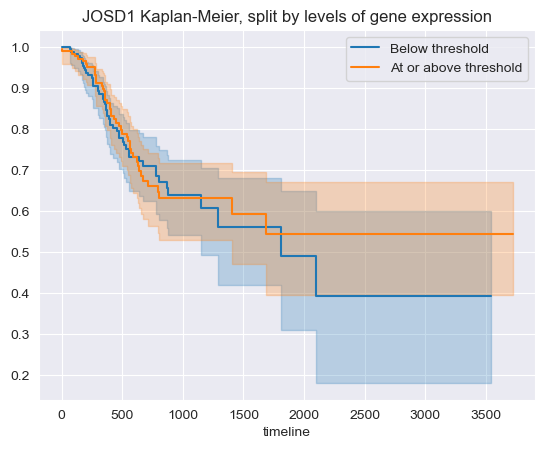

In [57]:
kaplan_meier_graph("JOSD1")

4. Multiple Test Corrections
* Given the very large dataset, we want to keep the error rate to <= the p-value cutoff; to avoid the many chances of a false positive.
* *What are we using to correct?* this code uses the 'standard' method of Benjamini/Hochberg
* https://www.graphpad.com/guides/prism/latest/statistics/stat_pros_and_cons_of_the_three_met.htm

In [58]:
from scipy.stats import false_discovery_control
df_stats['significance (p-values)'].dropna()
df_stats['BH corrected_significance'] = false_discovery_control(df_stats['significance (p-values)'], axis=0, method='bh')

In [59]:
adjusted_rank = df_stats.sort_values(by='BH corrected_significance', ascending=True)
adjusted_rank.head(10)

,Unnamed: 0,gene,significance (p-values),BH corrected_significance
0,10772,PPP1R3B,0.000003,0.045813
1,8454,C18orf2,0.000005,0.045813
10,13078,PCDHB4,0.000065,0.105386
8,14763,C5orf13,0.000059,0.105386
7,2895,RAB43,0.000050,0.105386
6,14959,JAKMIP1,0.000050,0.105386
9,5441,FAT3,0.000063,0.105386
4,16324,C21orf82,0.000041,0.105386
3,14698,SEC16A,0.000025,0.105386
2,1472,LRRC45,0.000022,0.105386


There seem to be only two genes that are statistically significant after this correction - PPP1R3B and C18orf2

Future: the statsmodels library includes a wide variety of multiple test corrections
* "one-step" corrections (have to do some more reading into this), negative correlated -> do not seem to be applicable here

In [60]:
from statsmodels.stats.multitest import multipletests

# Simes-Hochberg
df_stats['Simes-Hochberg corrected_significance'] = multipletests(df_stats['significance (p-values)'], alpha=.05, method='simes-hochberg', is_sorted=True)[1]

df_stats.sort_values(by='Simes-Hochberg corrected_significance', ascending=True)

,Unnamed: 0,gene,significance (p-values),BH corrected_significance,Simes-Hochberg corrected_significance
0,10772,PPP1R3B,0.000003,0.045813,0.052027
1,8454,C18orf2,0.000005,0.045813,0.091621
2,1472,LRRC45,0.000022,0.105386,0.387386
3,14698,SEC16A,0.000025,0.105386,0.444006
4,16324,C21orf82,0.000041,0.105386,0.742426
...,...,...,...,...,...
5993,343,STXBP6,0.248679,0.745398,0.999907
5992,384,C15orf24,0.248649,0.745398,0.999907
5991,13210,SON,0.248646,0.745398,0.999907
5997,11174,BEST3,0.248958,0.745810,0.999907


5. Cox Proportional Hazards Model

*What does it do?* The Cox Proportional Hazards model is a model for survival analysis that allows us to take multiple covariates, or predictors, into account when predicting survival outcome.
* Previously, we were checking survival rates for ONE GENE at a time, looking at expression levels

*Which genes are we considering?* Choosing the top 5 most variable genes from analysis. <-- Note: only two corrected p-values are statistically significant
 
*What variables (besides gene expressions) are we trying to look at?* Looking at some literature and considering what variables are available, I decided on: family_history_of_stomach_cancer, initial_weight, gender, age_at_initial_pathologic_diagnosis, pathologic_stage
* Also wanted to look at number_of_relatives_with_stomach_cancer, but most values are NA

In [5]:
# reimport
df_stats = pd.read_csv('results.csv')

In [6]:
from lifelines import CoxPHFitter

genes = ['PRTG', 'C18orf2', 'LRRC45', 'SEC16A', 'C21orf82']
classifiers = ['DSS.time', 'DSS', 'family_history_of_stomach_cancer', 'initial_weight', 'gender', 'age_at_initial_pathologic_diagnosis', 'pathologic_stage', 'lymph_node_examined_count', 'radiation_therapy']
columns = genes + classifiers
cph_data = df[columns].dropna(subset=columns, how='any', inplace=False)

# convert to numerical values as needed
cph_data['family_history_of_stomach_cancer'] = cph_data['family_history_of_stomach_cancer'].replace({'NO': 0, 'YES':1})

cph_data = cph_data[cph_data['radiation_therapy'] != '[Discrepancy]'] # drop rows w/discrepancy
cph_data['radiation_therapy'] = cph_data['radiation_therapy'].replace({'NO': 0, 'YES':1})

cph_data['gender'] = cph_data['gender'].replace({'MALE':0, 'FEMALE':1})

cph_data = cph_data[cph_data['pathologic_stage'] != '[Discrepancy]'] # drop rows w/discrepancy
cph_data['pathologic_stage'] = cph_data['pathologic_stage'].replace({
    'Stage I': 1,
    'Stage IA': 2,
    'Stage IB': 3,
    'Stage II': 4,
    'Stage IIA': 5,
    'Stage IIB': 6,
    'Stage III': 7,
    'Stage IIIA': 8,
    'Stage IIIB': 9,
    'Stage IIIC': 10,
    'Stage IV': 11,
})

cph = CoxPHFitter()
cph.fit(cph_data, duration_col='DSS.time', event_col='DSS')
print(cph.summary)
cph.plot()

/var/folders/f2/tk_xrkt15nx8hyv31k08sdjr0000gn/T/ipykernel_1367/2470509675.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cph_data['family_history_of_stomach_cancer'] = cph_data['family_history_of_stomach_cancer'].replace({'NO': 0, 'YES':1})
/var/folders/f2/tk_xrkt15nx8hyv31k08sdjr0000gn/T/ipykernel_1367/2470509675.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cph_data['radiation_therapy'] = cph_data['radiation_therapy'].replace({'NO': 0, 'YES':1})
/var/folders/f2/tk_xrkt15nx8hyv31k08sdjr0000gn/T/ipykernel_1367/2470509

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
PRTG                                 0.303115   1.354070  0.120954   
C18orf2                              0.017426   1.017578  0.084808   
LRRC45                               0.217323   1.242745  0.278782   
SEC16A                              -0.367590   0.692401  0.359911   
C21orf82                             0.278744   1.321469  0.279567   
family_history_of_stomach_cancer    -0.609286   0.543739  0.745639   
initial_weight                      -0.002827   0.997177  0.000902   
gender                              -1.566139   0.208850  0.538362   
age_at_initial_pathologic_diagnosis -0.006150   0.993869  0.018802   
pathologic_stage                     0.436437   1.547185  0.096104   
lymph_node_examined_count           -0.019907   0.980290  0.011583   
radiation_therapy                   -2.020052   0.132649  0.473079   

                   

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

In [12]:
print(df['h_pylori_infection'].isna().sum())

241
